In [4]:
# imports
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import cv2
import pandas as pd
import numpy as np

In [5]:
# load in data
ground_truth_frame = pd.read_csv("ground_truth.csv")

n = 0
image_name = ground_truth_frame.iloc[n, 0]

print("Image name ", image_name)
print("Shape of data ", ground_truth_frame.shape)

Image name  data/test/melanoma/ISIC_0012258.jpg
Shape of data  (600, 3)


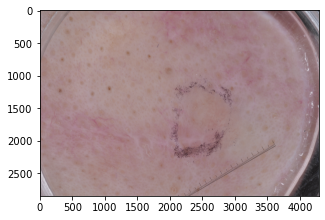

Classified as melanoma


In [9]:
# show an image from the data
n = 0
image_name = ground_truth_frame.iloc[n, 0]

plt.figure(figsize=(5,5))
plt.imshow(mpimg.imread(image_name))
plt.show()

melanoma_class = ground_truth_frame.iloc[n, 1]
if melanoma_class:
    print("Classified as melanoma")
else:
    print("Classified as benign")

In [20]:
# Data transformations
import torch
from torch.utils.data import Dataset, DataLoader

class SkinCancerDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.ground_truth_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.ground_truth_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.ground_truth_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        if (image.shape[2] == 4):
            image = image[:,:,0:3]
            
        true_class = self.ground_truth_frame.iloc[idx, 1:] #.as_matrix()
#         true_class = true_class.astype('float').reshape(-1, 2)
        sample = {'image': image, 'class': true_class}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

Length of dataset:  600
0 (4422, 6642, 3)
1 (4439, 6648, 3)
2 (2000, 3008, 3)


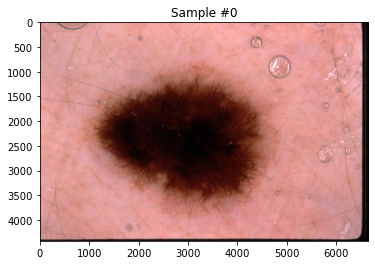

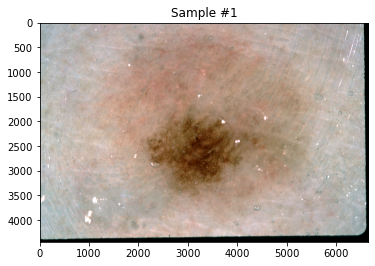

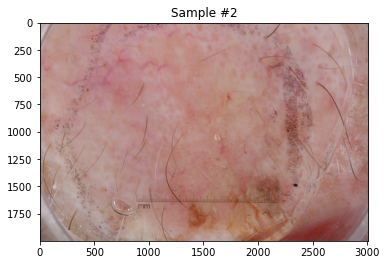

In [22]:
skin_dataset = SkinCancerDataset(csv_file='ground_truth.csv', root_dir='')
print("Length of dataset: ", len(skin_dataset))

num_to_display = 3

for i in range(num_to_display):
    fig = plt.figure(figsize=(20, 10))
    
    rand_i = np.random.randint(0, len(skin_dataset))
    sample = skin_dataset[rand_i]
    
    print(i, sample['image'].shape)
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    plt.imshow(sample['image'])

In [17]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

ModuleNotFoundError: No module named 'torch'